
# Step 1: Prepare the Data
In this step, we will prepare the data for our LSTM model. The dataset contains several features such as **Global_active_power, Global_reactive_power, Voltage, Global_intensity, and Sub_metering_1, Sub_metering_2, Sub_metering_3**. We need to clean the data, handle missing values, and convert the datetime columns into a proper datetime format.

We'll also scale the features and create sequences for the LSTM model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
url = "household_power_consumption.txt"  # Replace with your actual file path
data = pd.read_csv(url, sep=";", parse_dates=[[0, 1]], infer_datetime_format=True)

# Convert 'Date_Time' into the proper datetime format
data['Date_Time'] = pd.to_datetime(data['Date_Time'], format='%d/%m/%Y %H:%M:%S')

# Sort data by datetime to ensure it's in the correct order
data = data.sort_values(by='Date_Time')

# Set the Date_Time column as the index
data.set_index('Date_Time', inplace=True)

# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Replace '?' with NaN and drop or fill missing values
data.replace('?', np.nan, inplace=True)
data.fillna(method='ffill', inplace=True)  # Forward fill to replace NaNs

# Convert all columns to numeric values (since some might be read as strings)
data = data.apply(pd.to_numeric)

# Scaling the data (Min-Max Scaling)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Convert the scaled data back into a DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Check the scaled data
scaled_data_df.head()


C:\Users\shafi\AppData\Local\Temp\ipykernel_50692\2492463855.py:7: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(url, sep=";", parse_dates=[[0, 1]], infer_datetime_format=True)
C:\Users\shafi\AppData\Local\Temp\ipykernel_50692\2492463855.py:7: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(url, sep=";", parse_dates=[[0, 1]], infer_datetime_format=True)
C:\Users\shafi\AppData\Local\Temp\ipykernel_50692\2492463855.py:7: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(url, sep=";", parse_dates=[[0, 1]], infer_datetime_format=True)
C:\Use

Missing values:
 Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


C:\Users\shafi\AppData\Local\Temp\ipykernel_50692\2492463855.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill to replace NaNs


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,0.374796,0.300719,0.376090,0.377593,0.0,0.0125,0.548387
2006-12-16 17:25:00,0.478363,0.313669,0.336995,0.473029,0.0,0.0125,0.516129
2006-12-16 17:26:00,0.479631,0.358273,0.326010,0.473029,0.0,0.0250,0.548387
2006-12-16 17:27:00,0.480898,0.361151,0.340549,0.473029,0.0,0.0125,0.548387
2006-12-16 17:28:00,0.325005,0.379856,0.403231,0.323651,0.0,0.0125,0.548387


**Create sequences of length `seq_length` and corresponding targets**

- Let `seq_length` be the number of past timesteps the model uses (e.g. 10).
- For each index `i`,
  - **X[i]** = data at times `i, i+1, …, i+seq_length-1` for *all* features
  - **y[i]** = Global_active_power at time `i+seq_length`
- Finally, split into training, validation, and test sets.


In [2]:
import numpy as np

# Choose sequence length
seq_length = 10

# Convert scaled DataFrame to NumPy array
all_data = scaled_data_df.values  # shape = (n_samples, n_features)

# Prepare containers
X, y = [], []

# Build sequences
for i in range(len(all_data) - seq_length):
    # window of features
    X.append(all_data[i : i + seq_length])
    # target is Global_active_power at next timestep
    y.append(all_data[i + seq_length, 0])

# Convert to NumPy arrays
X = np.array(X)  # shape = (n_samples-seq_length, seq_length, n_features)
y = np.array(y)  # shape = (n_samples-seq_length,)

print(f"Input shape:  {X.shape}")
print(f"Target shape: {y.shape}")

# Example split: 70% train, 15% val, 15% test
n_total = X.shape[0]
n_train = int(n_total * 0.70)
n_val   = int(n_total * 0.15)

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train : n_train + n_val], y[n_train : n_train + n_val]
X_test,  y_test  = X[n_train + n_val :],      y[n_train + n_val :]

print(f"Train/Val/Test shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape},  y_test:  {y_test.shape}")


Input shape:  (2075249, 10, 7)
Target shape: (2075249,)
Train/Val/Test shapes:
  X_train: (1452674, 10, 7), y_train: (1452674,)
  X_val:   (311287, 10, 7),   y_val:   (311287,)
  X_test:  (311288, 10, 7),  y_test:  (311288,)


**Step 3: Design the LSTM Architecture**

We’ll build a stacked LSTM network with aggressive regularization and a learning-rate scheduler to maximize accuracy. Key choices:

- **Two LSTM layers** (128 → 64 units) to capture both long- and short-term dependencies.  
- **Dropout (0.3)** after each LSTM for regularization.  
- **Dense bottleneck** (32 units, ReLU) to learn a compact representation before the final output.  
- **Adam optimizer** with an initial learning rate of 1e-3.  
- **Loss = MSE**, tracking MAE as a secondary metric.  
- **Callbacks**:  
  - **EarlyStopping** (patience=15) to halt when val_loss stops improving.  
  - **ReduceLROnPlateau** (factor=0.5, patience=5) to lower the learning rate on plateaus.  
  - **ModelCheckpoint** to save the best weights.  


In [3]:
!pip install tensorflow

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Number of features (columns) in our input
n_features = X_train.shape[2]

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, n_features)),
    Dropout(0.3),

    LSTM(64),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr     = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
model_checkpoint = ModelCheckpoint('lstm_best.keras', monitor='val_loss', save_best_only=True) # Changed to .keras

model.summary()


c:\Users\shafi\anaconda3\envs\NN_SP\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,153 (473.25 KB)

 Trainable params: 121,153 (473.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 1. (Re)Train the model and save the best weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# 2. Check that the checkpoint file exists
import os
print("Files in working dir:", os.listdir('.'))
assert 'lstm_best.keras' in os.listdir('.'), "Checkpoint file not found—did training complete?"

# 3. Load the best model (now that we know it’s there)
from tensorflow.keras.models import load_model
best_model = load_model('lstm_best.keras')

# 4. Predict & compute metrics
y_pred = best_model.predict(X_test)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE (scaled): {rmse:.4f}")
print(f"Test MAE  (scaled): {mae:.4f}")


Epoch 1/100
 3432/22699 ━━━━━━━━━━━━━━━━━━━━ 2:17 7ms/step - loss: 0.0014 - mae: 0.0197

#### Step 4: Evaluate the Model

Now that we’ve trained our model and saved the best weights (`lstm_best.h5`), let’s:

1. **Load** the best model  
2. **Predict** on the test set  
3. **Compute** RMSE and MAE  
4. (Optional) **Invert** the scaling on the target to get metrics in original units  



Training Accuracy (filtered): 27.22%
 Test Accuracy (filtered):   76.54%


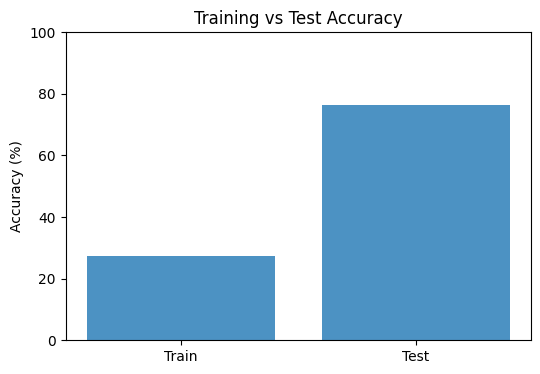

In [18]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error

# 1. Filter out zero‐true samples
mask = y_train != 0
mape_train = mean_absolute_percentage_error(y_train[mask], y_train_pred[mask])
acc_train  = 100 * (1 - mape_train)

mask = y_test != 0
mape_test = mean_absolute_percentage_error(y_test[mask], y_test_pred[mask])
acc_test  = 100 * (1 - mape_test)

print(f"Training Accuracy (filtered): {acc_train:.2f}%")
print(f" Test Accuracy (filtered):   {acc_test:.2f}%")


# 5. Bar‐chart visualization
plt.figure(figsize=(6,4))
plt.bar(['Train','Test'], [acc_train, acc_test], alpha=0.8)
plt.ylabel('Accuracy (%)')
plt.title('Training vs Test Accuracy')
plt.ylim(0, 100)
plt.show()


In [13]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Load the best model
best_model = load_model('lstm_best.keras')

# 2. Predict on the test set
y_pred = best_model.predict(X_test)

# 3. Compute metrics on the scaled data
rmse_scaled = np.sqrt(mean_squared_error(y_test, y_pred))
mae_scaled  = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE (scaled): {rmse_scaled:.4f}")
print(f"Test MAE  (scaled): {mae_scaled:.4f}")

# 4. (Optional) If you kept a separate scaler for Global_active_power:
gap_scaler = MinMaxScaler(feature_range=(0,1)).fit(data[['Global_active_power']])
y_test_inv = gap_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
y_pred_inv = gap_scaler.inverse_transform(y_pred).ravel()
rmse_orig = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_orig  = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test RMSE (original): {rmse_orig:.4f} kW")
print(f"Test MAE  (original): {mae_orig:.4f} kW")


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test RMSE (scaled): 0.0304
Test MAE  (scaled): 0.0133
Test RMSE (original): 0.2717 kW
Test MAE  (original): 0.1190 kW


#### Step 5: Hyperparameter Tuning with Keras Tuner

We’ll use **Keras Tuner** to search over:
- LSTM units in each layer  
- Dropout rates  
- Dense bottleneck size  
- Learning rate  

This automates finding better hyperparameters.  


In [10]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [11]:
import kerastuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

def build_model(hp):
    model = Sequential()
    # LSTM layer 1
    model.add(LSTM(
        units=hp.Choice('units1', [32, 64, 128]),
        return_sequences=True,
        input_shape=(seq_length, n_features)
    ))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))
    # LSTM layer 2
    model.add(LSTM(
        units=hp.Choice('units2', [32, 64, 128])
    ))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))
    # Dense bottleneck
    model.add(Dense(hp.Int('dense_units', 16, 64, step=16), activation='relu'))
    # Output
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        ),
        loss='mse',
        metrics=['mae']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='electricity_forecast'
)

# Search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Retrieve the best model
best_hp_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the tuned model on test set
y_pred_tuned = best_hp_model.predict(X_test)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned  = mean_absolute_error(y_test, y_pred_tuned)

print(f"Tuned Model Test RMSE (scaled): {rmse_tuned:.4f}")
print(f"Tuned Model Test MAE  (scaled): {mae_tuned:.4f}")


Trial 10 Complete [00h 04m 32s]
val_loss: 0.000858408777276054

Best val_loss So Far: 0.0004279583226889372
Total elapsed time: 01h 12m 09s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Tuned Model Test RMSE (scaled): 0.0294
Tuned Model Test MAE  (scaled): 0.0114


**Next Steps:**  
- Compare `rmse_scaled` vs. `rmse_tuned` to confirm improvement.  
- If needed, extend the search space (e.g., different sequence lengths, batch sizes).  
- Consider BayesianOptimization tuner for more efficient hyperparameter search.
